In [71]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


# Importing the input data

In [64]:
training  = pd.read_csv('/kaggle/input/titanic/train.csv')
testing = pd.read_csv('/kaggle/input/titanic/test.csv')



training['train_test']  = 1
testing['train_test'] = 0
testing['Survived'] =np.NaN
all_data = pd.concat([training,testing])
%matplotlib inline

training.shape,testing.shape,all_data.shape,all_data.columns


((891, 13),
 (418, 13),
 (1309, 13),
 Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
        'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'train_test'],
       dtype='object'))

In [9]:
#looking at null counts and data types in the data 
training.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


# Projcet outlines

*  Data Exploration & Data visualization
*  Feature enginerring
*  Preprocess data
*  Model Baseline

# Data Exploration & Data visualization

 ## 1) Numeric data
* Looking at some important central tendencies of the data
* Use histograms to understand distributions 
* corrplot to understand the relationships between variables in a dataset
 

In [10]:
# central tendencies of the numeric data
training.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


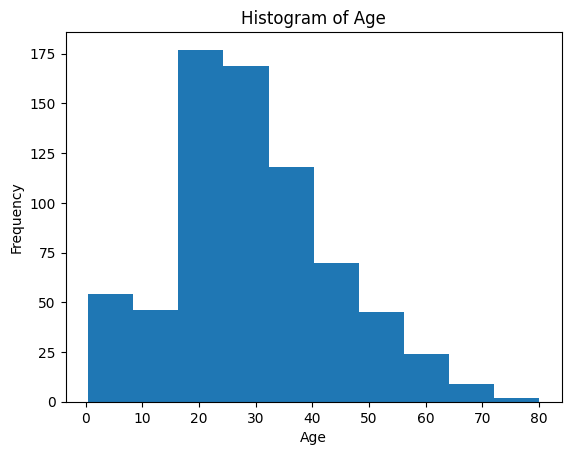

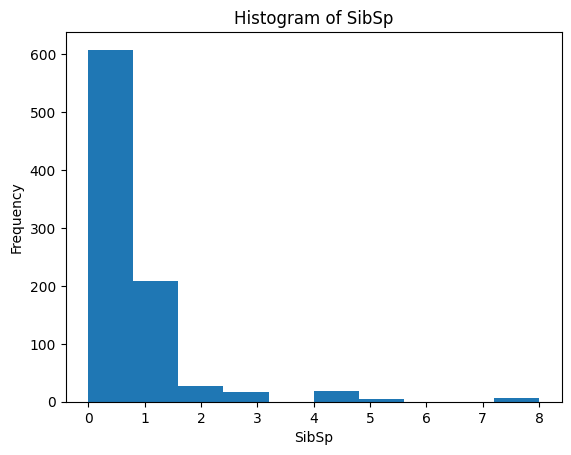

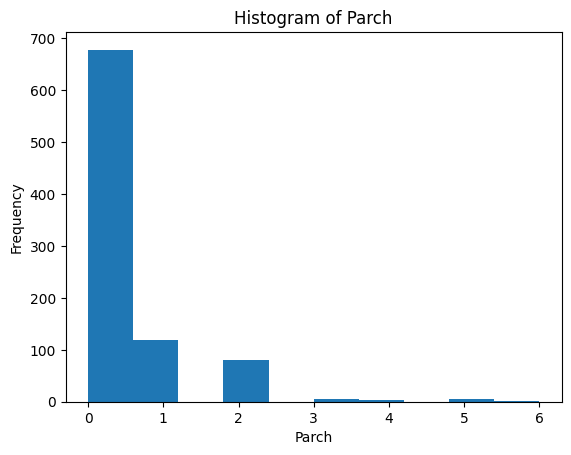

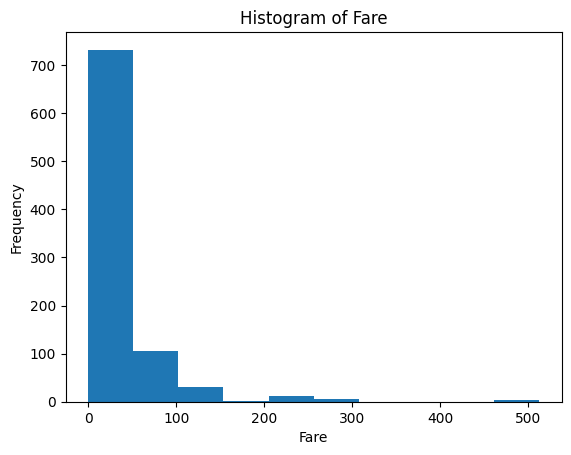

In [12]:
# Use histograms to understand distributions

# Select numeric columns that can be valuable
numeric_cols = training[['Age','SibSp','Parch','Fare']]
# Set up the matplotlib figure
# Plot histograms
for column in numeric_cols.columns:
    plt.hist(numeric_cols[column])
    plt.title(f'Histogram of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.show()

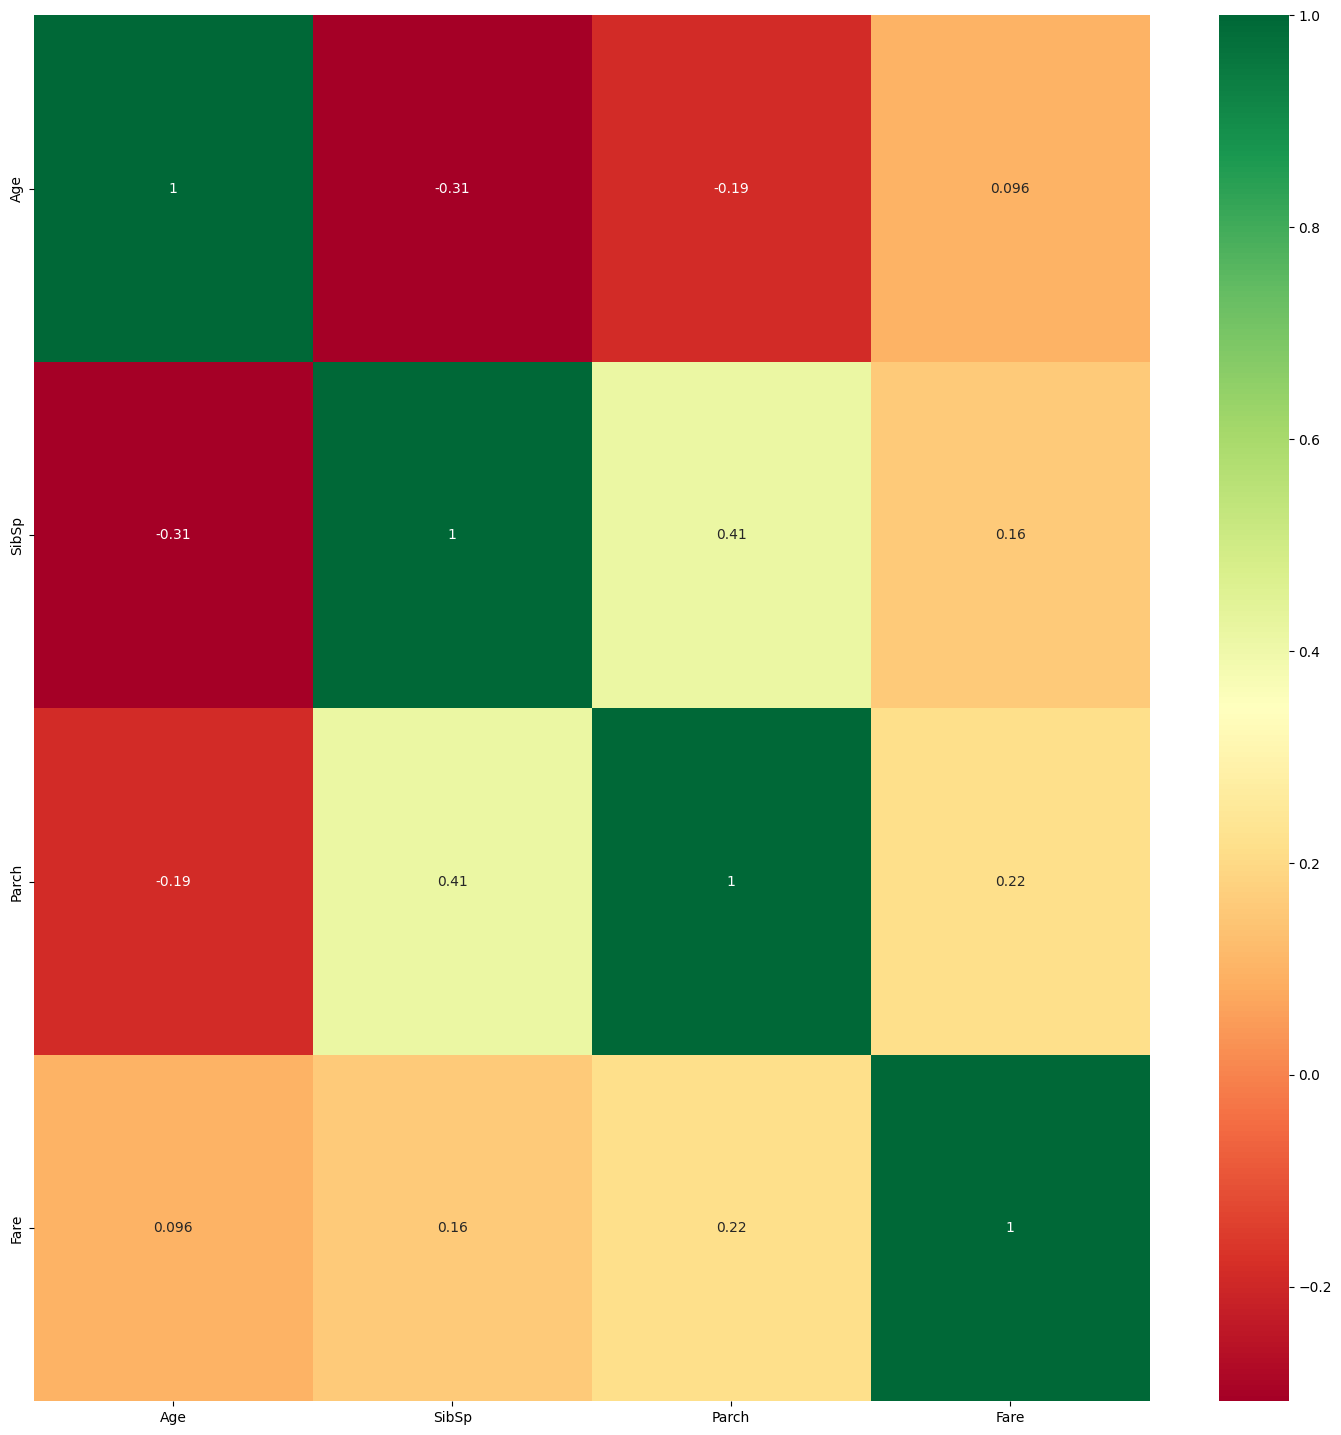

In [16]:
# Corrplot to understand the relationships between variables in numeric columns only
corr_matrix = numeric_cols.corr()

# Ues heatmap to plot the correlation matrix
plt.figure(figsize =(18,18))
sns.heatmap(corr_matrix,annot= True,cmap='RdYlGn')
plt.show()

# 2) categorical data 
* count plot to see the frequency or count of each category
* plot the relationship between each unique value of categorical variables and the number of survivors

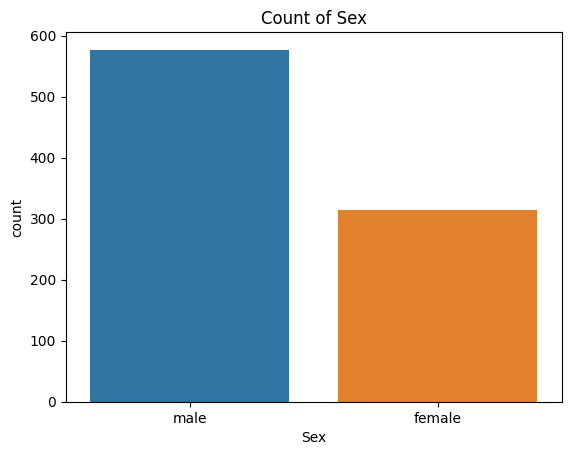

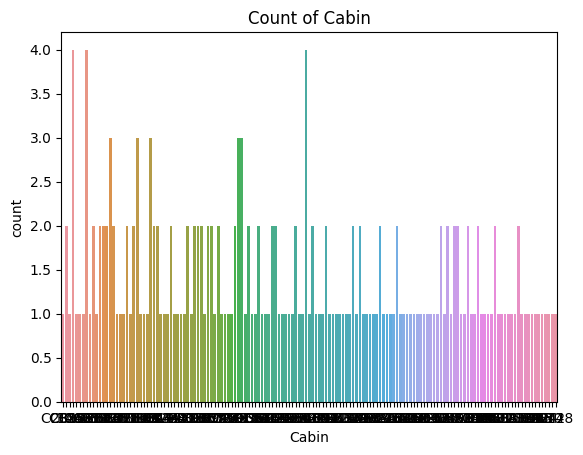

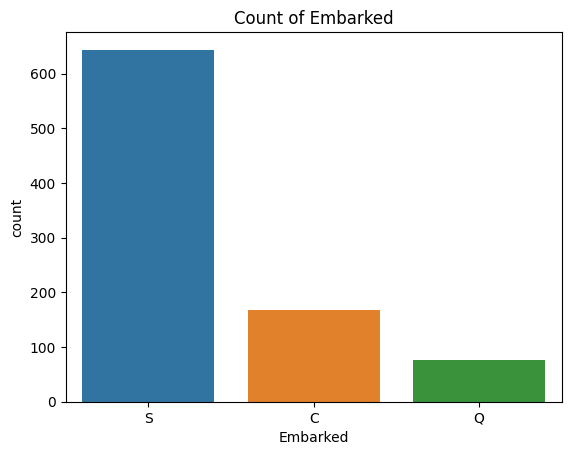

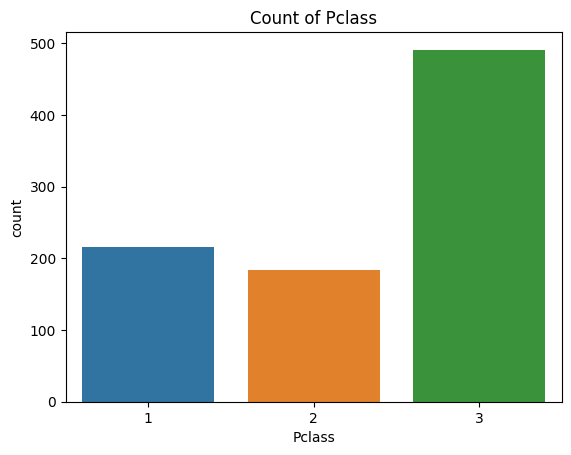

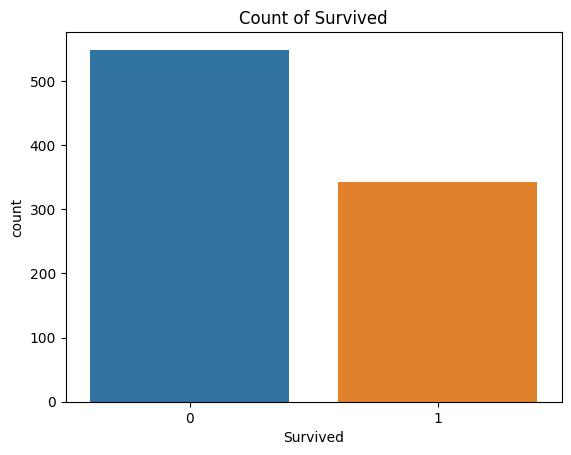

In [30]:
# Select the categorical data 
cate_cols = training[['Sex','Cabin','Embarked','Pclass','Survived']]

for col in cate_cols.columns:
    sns.countplot( x=col,data =cate_cols )
    plt.title(f'Count of {col}')
    plt.ylabel('count')
    plt.xlabel(col)
    plt.show()


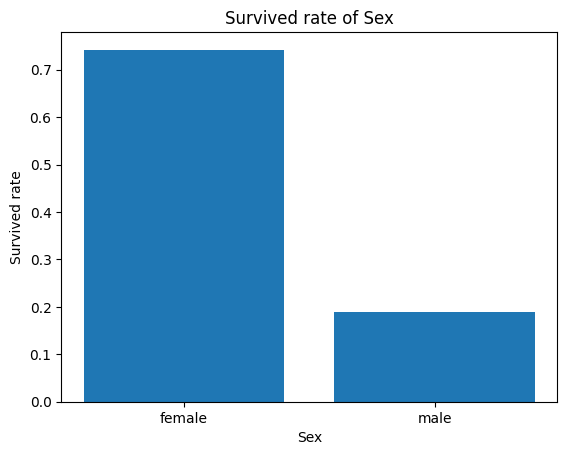

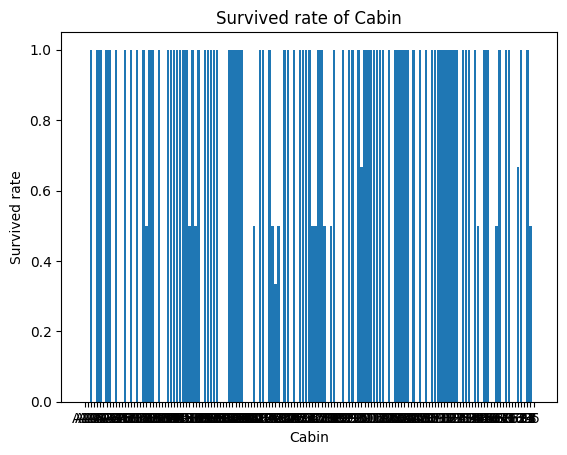

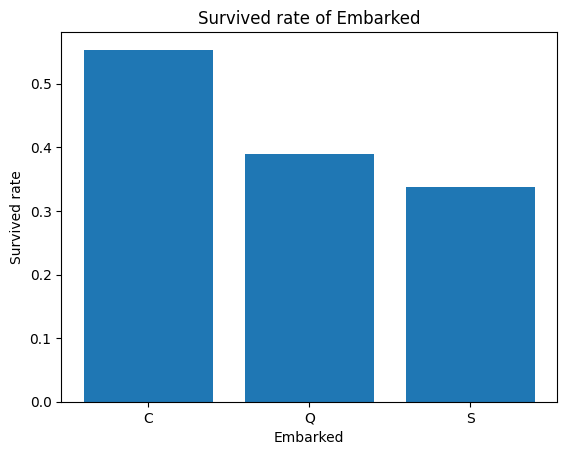

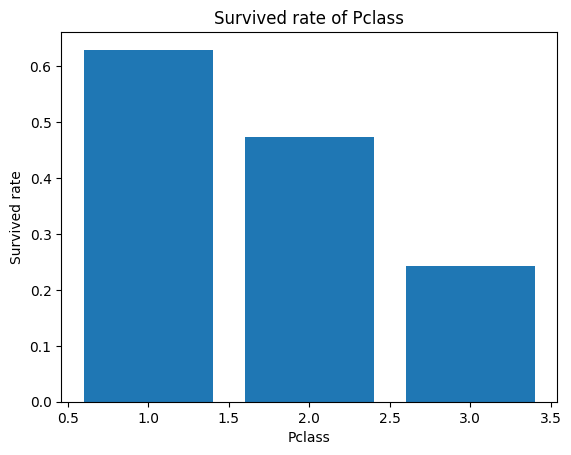

In [54]:
# plot the relationship between each unique 
# value of categorical variables and the number of survivors


target_var = 'Survived'

# Plot the relationship between each categorical variable and the number of survivors
for col in cate_cols.columns:
    if (col ==target_var ):
        break
    # Aggregate data by the categorical variable and count survivors
    surv_count = training.groupby(col)[target_var].sum()
    total_count = training.groupby(col)[target_var].count()
    surv_rate = surv_count / total_count
   
    # Plot
    plt.bar(surv_rate.index,surv_rate.values)
    plt.title(f'Survived rate of {col}')
    plt.ylabel('Survived rate')
    plt.xlabel(col)
    plt.show()

# Feature engineering
 ## 1) Cabin Data
> simplify cabins to a letter and number 

In [56]:
# taking the first letter to test if it had an effact on Survived rate 
# n stands for Nan (null)
training['cabin_cate'] = training.Cabin.apply(lambda x: str(x)[0])
training['cabin_cate'].value_counts()

cabin_cate
n    687
C     59
B     47
D     33
E     32
A     15
F     13
G      4
T      1
Name: count, dtype: int64

## 2) Names data
> person's title



In [62]:
training['name_title'] = training.Name.apply(lambda x: x.split(',')[1].split('.')[0].strip())
training['name_title'].value_counts()

name_title
Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Mlle              2
Major             2
Col               2
the Countess      1
Capt              1
Ms                1
Sir               1
Lady              1
Mme               1
Don               1
Jonkheer          1
Name: count, dtype: int64

# Preprocess data

In [69]:
all_data['cabin_cate'] = all_data.Cabin.apply(lambda x: str(x)[0])
all_data['name_title'] = all_data.Name.apply(lambda x: x.split(',')[1].split('.')[0].strip())

# impute nulls for continous data
all_data.Age =all_data.Age.fillna(training.Age.mean())
all_data.Fare =all_data.Fare.fillna(training.Fare.mean())

# drop null becuse it can not be filled
all_data.dropna(subset='Embarked',inplace= True)

# transfom to log norm
all_data['norm_fare'] = np.log(all_data.Fare+1)

# converted fare to str to pd.get_dumies()
all_data.Pclass = all_data.Pclass.astype(str)

# all dummy variable
all_dummies = pd.get_dummies(all_data[['Pclass','Sex','Age','SibSp','Parch',
                                      'norm_fare','Embarked','cabin_cate','name_title',
                                       'train_test']])
#Split to train test again

X_train = all_dummies[all_dummies.train_test ==1].drop(['train_test'],axis =1)
X_test = all_dummies[all_dummies.train_test ==0].drop(['train_test'],axis =1)

y_train = all_data[all_data.train_test==1].Survived

# Model Baseline

In [72]:
model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=1)
model.fit(X_train, y_train)
predictions = model.predict(X_test)

output = pd.DataFrame({'PassengerId': testing.PassengerId, 'Survived': predictions})
output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!
